# ESM3 Analysis for 2004 -2014
The purpose of this notebook is to access the CMIP6 data sets and present the ESM1 temperature data from historic simulations. Dask functionality has been added to improve speed of calculations, and functions have been implements to reduce the number of cells that require running for different dates.

The [plotted data](#Presentation-of-data) can be found in the bottom half of the document.

#### Dask Import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33383")
client

Client Scheduler: tcp://127.0.0.1:33383 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 7 Memory: 45.10 GB


<br>

#### Choices for data

In [2]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceID = 'E3SM-1-0'

#Ocean Area data for averaging 
areaVariableId = 'areacello'
areaSourceId = 'CESM2'
areaDataSetNo = 1 #First database in results to be used

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
levSel = 5.0

<br>

#### Imports

In [3]:
import cartopy.crs as ccrs
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


<br>

#### Accessing Dataset Database

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
print("Database accessed")

Database accessed


<br>

#### Filtering for relevant data sets
ESM3 data sets

In [5]:
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceID)]
print(str(len(dfFilt))+" datasets found.")
dfFilt

5 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
270900,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190826
271560,CMIP,E3SM-Project,E3SM-1-0,historical,r2i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190830
401370,CMIP,E3SM-Project,E3SM-1-0,historical,r4i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
401372,CMIP,E3SM-Project,E3SM-1-0,historical,r3i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
430597,CMIP,E3SM-Project,E3SM-1-0,historical,r5i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200429


<br>
Ocean area data to be used for averaging

In [6]:
dfArea = df[df.variable_id.eq(areaVariableId) & df.source_id.eq(areaSourceId)]
print(str(len(dfArea))+" datasets found.")
dfArea.head()

73 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
57950,CMIP,NCAR,CESM2,historical,r3i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
57951,CMIP,NCAR,CESM2,historical,r3i1p1f1,Ofx,areacello,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
58402,CMIP,NCAR,CESM2,historical,r5i1p1f1,Ofx,areacello,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
58403,CMIP,NCAR,CESM2,historical,r5i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
59011,CMIP,NCAR,CESM2,historical,r6i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...,NaN,20190308


<br>

#### Opening all datafiles
ESM3 data

In [7]:
fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)
if fileCount:
    print(str(fileCount)+" ESM3 data sets opened")
else:
    print("No ESM3 data sets opened")

5 ESM3 data sets opened


Ocean Area data

In [8]:
dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[areaDataSetNo]), consolidated=True)
dataAreaRaw = dsArea.areacello
print("Ocean Area data loaded")

Ocean Area data loaded


<br>

#### Combine data sets into one xarray

In [9]:
for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='SetId') #Combining data sets
print("Data sets successfully merged")
#fileSet #Uncomment to see full data set

Data sets successfully merged


<br>

#### Selection of Data

In [10]:
dataFiltLatLev = fileSet.thetao.sel(lat=latSel, lev=levSel) #Selection of latitude and depth
dataFiltFull = dataFiltLatLev.reset_coords(drop=True) #Removes lev if single value
print("Finished data selection")
#dataFiltFull #Uncomment to see filtered data set

Finished data selection


<br>

#### Time identification

In [11]:
globalStartDate = dataFiltFull["time"][0].values
globalDateInc = dataFiltFull["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dataFiltFull["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("Data start date: "+globalStartDateStr)
print("Data end date (included): "+str(globalEndDateInStr))
print("Data end date (excluded): "+str(globalEndDateOutStr))
print("Data increments in steps of "+str(globalDateInc))

Data start date: 1850-01
Data end date (included): 2014-12
Data end date (excluded): 2015-01
Data increments in steps of 2678400000000000 nanoseconds


<br>

#### Calculation
Functions: <br>
meanTemp - Calculates the Southern Ocean mean temperature for a given data set <br>
dateCheck1 - Takes in a single date and checks to see if it is inside the data set. If not then the nearest valid date is returned<br>
dateCheck2 - Takes in a pair of dates (start and end) and checks to see if they are ordered correctly (start before end) and that both dates are inside the data set. If not then the nearest valid dates are returned<br>
singleSoloDateCalc - Calculates and displays the Ocean temperature at all locations from a selected data set,  prints mean ocean temperature <br>
singleAllDateCalc - Calculates and displays the Ocean temperature at all locations from all data sets,  prints mean ocean temperature <br>
rangeSoloCompareCalc - Calculates and displays the change in ocean temperature between two dates for a selected data set, prints mean ocean temperature and change<br>
rangeAllCompareCalc - Calculates and displays the change in ocean temperature between two dates for all data sets, prints mean ocean temperature and change<br>
rangeSoloDateCalc - Calculates and displays the mean Ocean temperature as a line plot for a given time period from a selected data set <br>
rangeAllDateCalc - Calculates and displays the mean Ocean temperature as a line plot for a given time period from all data sets, can also show standard deviation for data <br>

Global Data: <br>
dataAreaSH - Ocean area data for the selected latitudes ([latSec](#Choices-for-data)), taken from first [areacello](#Accessing-Dataset-Database) database <br>
totalArea - The sum of all the area in dataAreaSH ([see above](#Calculation))

In [12]:
@delayed
def meanTemp(dataSet):
    '''Calculates and returns Mean Ocean temperature for a given data set.
    Requires global dataAreaSH, totalArea'''
    return (dataSet*dataAreaSH).sum(dim=['lon', 'lat']) / totalArea 

dataAreaSH = dataAreaRaw.sel(lat=latSel) #Selecting data for relevant latittude
totalArea = dataAreaSH.sum(dim=['lon', 'lat']) #Summing selected area

def dateCheck1(Date):
    '''Takes date input, check to ensure that date is valid for the data set, modifying it if not.
    Requires global globalStartDate, globalEndDate, globalStartDateStr, globalEndDateStr'''
    if np.datetime64(Date ,'M') < globalStartDate:
        Date = globalStartDateStr
    elif np.datetime64(Date ,'M') > globalEndDateOut:
        Date = globalEndDateInStr
    return Date

def dateCheck2(startDate, endDate):
    '''Takes start and end date input, check to ensure that both dates are valid for the data set, modifying them if not.
    Requires global globalStartDate, globalEndDate, globalStartDateStr, globalEndDateStr'''
    if np.datetime64(startDate ,'M') > np.datetime64(endDate ,'M'):
        startDate, endDate = endDate, startDate
    if np.datetime64(startDate ,'M') < globalStartDate:
        startDate = globalStartDateStr
        if np.datetime64(endDate ,'M') < globalStartDate:
            endDate = globalStartDateStr
    if np.datetime64(endDate ,'M') > globalEndDateOut:
        endDate = globalEndDateOutStr
        if np.datetime64(startDate ,'M') > globalEndDateOut:
            startDate = globalEndDateInStr
    return startDate, endDate

def singleSoloDateCalc(date,setId,plotNo):
    '''Calculates and displays Ocean temperature for a selected date, prints mean ocean temperature, uses only 1 data set.
    Requires global dataFiltFull, dataAreaSH, totalArea'''
    singleData = dataFiltFull.sel(SetId=setId, time=date)
    singleTemp = meanTemp(singleData)
    valuesSingleTemp = singleTemp.compute()
    singleTimePlot(singleData,date, valuesSingleTemp.values[0], str(setId), plotNo)
    
def singleAllDateCalc(date, stdBool, plotNo):
    '''Calculates and displays Ocean temperature for a selected date, prints mean ocean temperature, averages all data sets.
    Requires global dataFiltFull, dataAreaSH, totalArea'''
    multiData = dataFiltFull.sel(time=date)
    meanData = multiData.mean("SetId", keep_attrs =True)
    meanData.compute()
    multiTemps = meanTemp(multiData)
    valuesMultiTemps = multiTemps.compute()
    valuesMeanTemp = valuesMultiTemps.mean("SetId")
    valuesMeanTemp.compute()
    singleTimePlot(meanData, date, valuesMeanTemp.values[0], "All", plotNo)
    if stdBool:
        stdData = multiData.std("SetId", keep_attrs =True)
        stdData.compute()
        valuesStdTemp = stdData.mean(["lon", "lat"])
        valuesStdTemp.compute()
        singleTimePlotStd(stdData, date, valuesStdTemp.values[0], plotNo+1)

def rangeSoloCompareCalc(startDate, endDate, setId, plotNo):
    '''Calculates and displays change in Ocean temperature for two dates for a given data set, prints mean ocean temperature at both time dates and the difference.
    Requires global dataFiltFull, dataAreaSH, totalArea'''
    startData = dataFiltFull.sel(SetId=setId, time=startDate)
    endData = dataFiltFull.sel(SetId=setId, time=endDate)
    diffData = startData.copy()
    diffData.values = (endData.values - startData.values)
    singleTemp = meanTemp(diffData)
    valuesSingleTemp = singleTemp.compute()
    singleTimePlot(diffData,endDate+" vs "+startDate, valuesSingleTemp.values[0], str(setId), plotNo)
    
def rangeAllCompareCalc(startDate, endDate, stdBool, plotNo):
    '''Calculates and displays change in Ocean temperature for two dates for a given data set, prints mean ocean temperature at both time dates and the difference.
    Requires global dataFiltFull, dataAreaSH, totalArea'''
    startData = dataFiltFull.sel(time=startDate)
    endData = dataFiltFull.sel(time=endDate)
    diffData = startData.copy()
    diffData.values = (endData.values - startData.values)
    meanDiffData = diffData.mean("SetId", keep_attrs =True)
    meanDiffData.compute()
    singleTemp = meanTemp(meanDiffData)
    valuesSingleTemp = singleTemp.compute()
    singleTimePlot(meanDiffData,endDate+" vs "+startDate, valuesSingleTemp.values[0], "All", plotNo)
    if stdBool:
        stdData = diffData.std("SetId", keep_attrs =True)
        stdData.compute()
        valuesStdTemp = stdData.mean(["lon", "lat"])
        valuesStdTemp.compute()
        singleTimePlotStd(stdData, endDate+" vs "+startDate, valuesStdTemp.values[0], plotNo+1)
    
def rangeSoloDateCalc(startDate, endDate, setId, plotNo):
    '''Calculates and displays Ocean temperature for a time period, prints mean ocean temperature, uses only 1 data set.
    Requires global dataFiltFull, dataAreaSH, totalArea'''
    startDate, endDate = dateCheck2(startDate, endDate)
    multiData = dataFiltFull.sel(SetId=setId, time=slice(startDate, endDate))
    multiTemp = meanTemp(multiData)
    valuesMultiTemp = multiTemp.compute()
    multiTimePlot(valuesMultiTemp, startDate, endDate, str(setId), plotNo)

def rangeAllDateCalc(startDate, endDate, stdBool , plotNo):
    '''Calculates and displays Ocean temperature for a time period, prints mean ocean temperature, uses all data sets.
    Requires global dataFiltFull, dataAreaSH, totalArea. Use for small time ranges (1 month - 12 months)'''
    startDate, endDate = dateCheck2(startDate, endDate)
    multiDatas = dataFiltFull.sel(time=slice(startDate, endDate))
    multiTemps = meanTemp(multiDatas)
    valuesMultiTemps = multiTemps.compute()
    meanMultiTemp = valuesMultiTemps.mean("SetId", keep_attrs =True)
    meanMultiTemp.compute()
    multiTimePlot(meanMultiTemp, startDate, endDate, 'All', plotNo)
    if stdBool:
        stdMultiTemp = valuesMultiTemps.std("SetId", keep_attrs =True)
        stdMultiTemp.compute()
        multiTimePlotStd(stdMultiTemp, startDate, endDate, plotNo + 1)
    
def rangeAllDateCalc2(startDate, endDate, stdBool, plotNo):
    '''Calculates and displays Ocean temperature for a time period, prints mean ocean temperature, uses all data sets.
    Requires global dataFiltFull, dataAreaSH, totalArea. Use for large time ranges (6 months +)'''
    startDate, endDate = dateCheck2(startDate, endDate)
    dateArrayPart = np.arange(np.datetime64(startDate ,'M'), np.datetime64(endDate ,'M'), np.timedelta64(12, 'M')) #Splits dates into 12 month segments
    dateArrayFull = np.append(dateArrayPart, np.datetime64(endDate, 'M')) #Appends end date
    if (dateArrayFull[-2]+np.timedelta64(5,'M')) > dateArrayFull[-1]:
        dateArrayFull[-2] = dateArrayFull[-1] - np.timedelta64(6,'M')
    fullTempsList = []
    for i in range(len(dateArrayFull)-2):
        partData = dataFiltFull.sel(time = slice(dateArrayFull[i], dateArrayFull[i+1] - np.timedelta64(1, 'M') ))
        partTemps = meanTemp(partData)
        valuesMultiTemps = partTemps.compute()
        fullTempsList.append(valuesMultiTemps)
    partData = dataFiltFull.sel(time = slice(dateArrayFull[-2], dateArrayFull[-1]))
    partTemps = meanTemp(partData)
    valuesMultiTemps = partTemps.compute()
    fullTempsList.append(valuesMultiTemps)
    fullTemps = xr.combine_nested(fullTempsList, concat_dim="time")   
    meanFullTemp = fullTemps.mean("SetId", keep_attrs =True)
    meanFullTemp.compute()
    multiTimePlot(meanFullTemp, startDate, endDate, 'All', plotNo)
    if stdBool:
        stdFullTemp = fullTemps.std("SetId", keep_attrs =True)
        stdFullTemp.compute()
        multiTimePlotStd(stdFullTemp, startDate, endDate, plotNo + 1)
        
def rangeSoloCompareCal(startDate1, startDate2, months, setId, plotNo):
    startDate1 = np.datetime64(startDate1, 'M')
    startDate2 = np.datetime64(startDate2, 'M')
    endDate1 = startDate1 + np.timedelta64(months-1, 'M')
    endDate2 = startDate2 + np.timedelta64(months-1, 'M')
    subData1 = dataFiltFull.sel(time=slice(startDate1, endDate1),SetId=setId)
    subData2 = dataFiltFull.sel(time=slice(startDate2, endDate2),SetId=setId)
    subData2copy = subData2.copy()
    timeDiff = startDate2 - startDate1
    
    for i in range(months):
        subData2copy['time'].values[i] = np.datetime64(subData2['time'].values[i], 'M') - timeDiff

    multiSub1 = meanTemp(subData1)
    valuesSub1Temps = multiSub1.compute()
    multiSub2 = meanTemp(subData2copy)
    valuesSub2Temps = multiSub2.compute()
    multiTimePlotCompare(valuesSub1Temps, valuesSub2Temps, str(startDate1), str(startDate2), months,str(setId),plotNo)   
        
print("Calculation functions defined")

Calculation functions defined


<br>

#### Presentation of data
Functions: <br>
singleTimePlot - Displays the Ocean temperature at all locations from a given data set, prints mean ocean temperature. <br>
singleTimePlotStd - Displays the Ocean temperature standard deviation at all locations from a given data set, prints mean ocean temperature standard deviation. <br>
multiTimePlot - Displays the mean Ocean temperature from a given data set as a line plot <br>
multiTimePlotStd - Displays the standard deviation of Ocean temperature from a given data set as a line plot <br>

In [13]:
def singleTimePlot(dataSet, date, meanValue, setStr, plotNo):
    '''Displays Ocean temperature for given data set on a map, prints mean ocean temperature'''
    plt.figure(plotNo)
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),cmap='RdBu_r',robust=True,
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title("Southern Ocean Temp - " + str(date) + " ("+str(setStr)+")")
    print("Average Ocean temperature for plot "+str(plotNo)+" ("+date+")(Set "+str(setStr)+"): "+str(round(meanValue,3))+" Celsius")
    
def singleTimePlotStd(dataSet, date, stdValue, plotNo):
    '''Displays Ocean temperature standard deviation for given data set on a map, prints mean ocean temperature'''
    plt.figure(plotNo)
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),cmap='RdBu_r',robust=True,
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title("Southern Ocean Temp Std - " + str(date))
    print("Average Ocean temperature standard deviation for plot "+str(plotNo)+" ("+date+"): "+str(round(stdValue,3))+" Celsius")
    
def multiTimePlot(dataSet, startDate, endDate, setStr, plotNo):
    '''Displays Ocean temperature for given data set as line graph'''
    plt.figure(plotNo)
    dataSet.plot(label='Monthly Mean (Set '+str(setStr)+')')
    if (np.datetime64(startDate,'M') + np.timedelta64(12,'M')) < np.datetime64(endDate,'M'): #Check to ensure there is sufficent range in the data set for rolling average
        dataSetRollingMean = dataSet.rolling(time=12).mean()
        dataSetRollingMean.plot(label='12 month rolling mean (Set '+str(setStr)+')')
        print("Mean Annual rolling Temp on "+str(np.datetime64(startDate,'M')+np.timedelta64(11, 'M'))+" (set "+str(setStr)+"): "+str(round(dataSetRollingMean.values[11], 3))+" Celcius")
        print("Mean Annual rolling Temp on "+str(endDate)+" (set "+str(setStr)+"): "+str(round(dataSetRollingMean.values[-1],3))+" Celcius")
        print("Mean Rolling Temp increase across time (set "+str(setStr)+"): "+str(round(dataSetRollingMean.values[-1] - dataSetRollingMean.values[11],4))+" Celcius")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Mean Southern Ocean Temp - " + str(startDate)+" to "+str(endDate))
    
def multiTimePlotCompare(dataSet1, dataSet2, startDate1, startDate2, months, setStr, plotNo):
    '''Displays Ocean temperature for two given data sets as a line graph'''
    plt.figure(plotNo)
    dataSet1.plot(label='Monthly Mean for '+startDate1+" series")
    dataSet2.plot(label='Monthly Mean for '+startDate2+" series")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Mean Southern Ocean Temp - " + str(startDate1)+" and "+str(startDate2)+" for "+str(months)+" months (Set "+setStr+")")
    
def multiTimePlotStd(dataSet, startDate, endDate, plotNo):
    '''Displays Ocean temperature standard devation for given data set as line graph'''
    plt.figure(plotNo)
    dataSet.plot(label='Monthly Std')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Mean Southern Ocean Temp Deviation - " + str(startDate)+" to "+str(endDate)+" ("+str(fileCount)+" datasets)")
    
print("Plotting functions defined")

Plotting functions defined


<br>
<b>Temperature profile for 2004</b><br>
The ocean temperature varies on a monthly basis. To identify the highest and lowest temperature months the average temperature profile of 2004 is plotted, with the standard deviation for each month shown on the second plot.

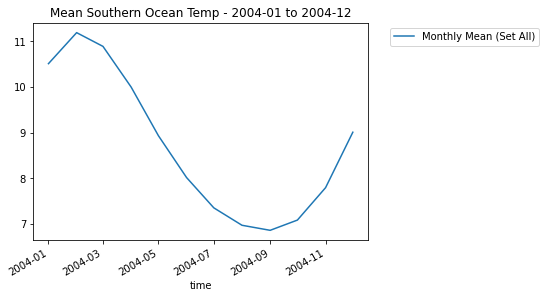

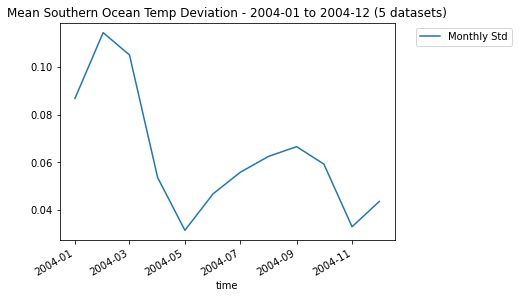

In [14]:
rangeAllDateCalc('2004-01','2004-12', True, 1)

From the above plots the warmest month can be identified as Febuary, with the coldest closely being September, with August and October being close. 

<br>
<b>Temperature profile for 2014</b><br>
For easy comparison the profile of 2014 is shown below. It can be seen to also follow the trend of having a warmest Febuary and coldest September, with close cold values in August and October.

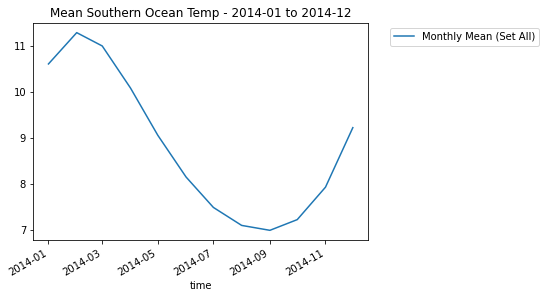

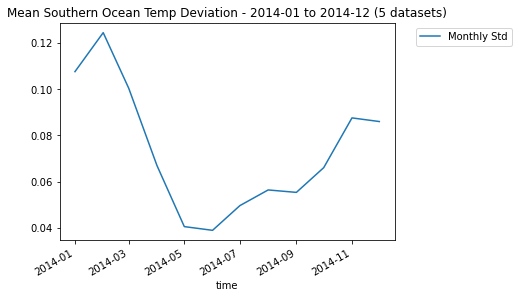

In [15]:
rangeAllDateCalc('2014-01','2014-12', True, 1)

<br>
<b>Direct comparison of 2004 with 2014</b><br>
The temperature profile of these two years can be directly compared (Currently across only a single data set) and plotted on the same time axis (using the first years dates).

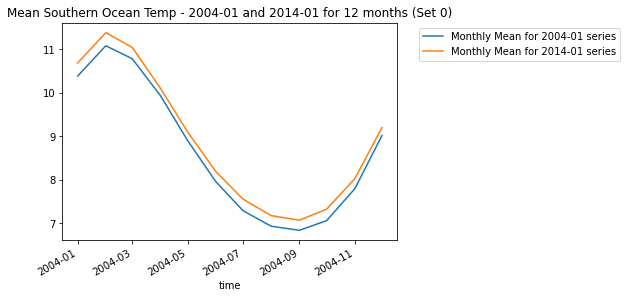

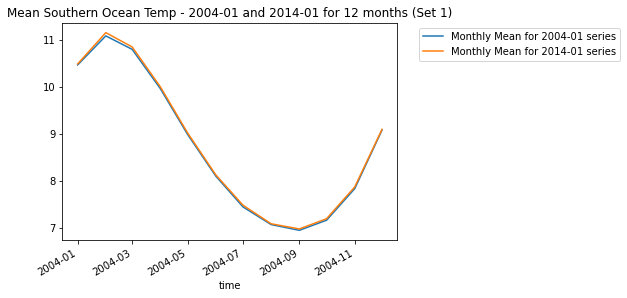

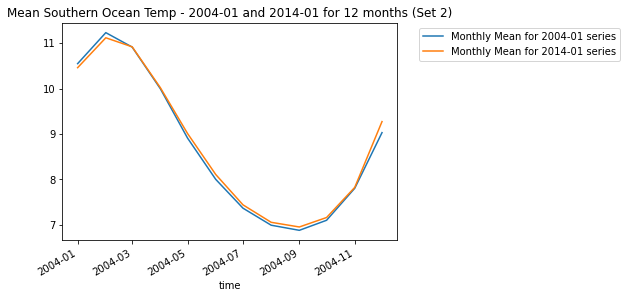

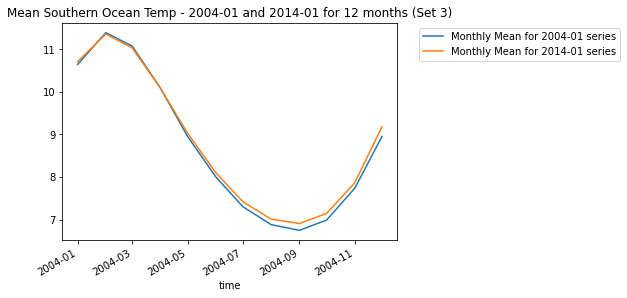

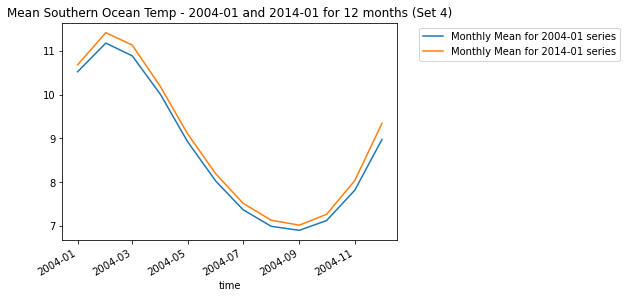

In [16]:
for i in range(fileCount):
    rangeSoloCompareCal('2004-01','2014-01',12,i,i)

<br>
<b>Comparison of Southern Ocean Temperature Febuary 2004 - 2014</b><br>
Temperature and standard deviation plots across all data sets for start and end time.

Average Ocean temperature for plot 1 (2004-02)(Set All): 11.192 Celsius
Average Ocean temperature standard deviation for plot 2 (2004-02): 0.56 Celsius
Average Ocean temperature for plot 3 (2014-02)(Set All): 11.285 Celsius
Average Ocean temperature standard deviation for plot 4 (2014-02): 0.569 Celsius


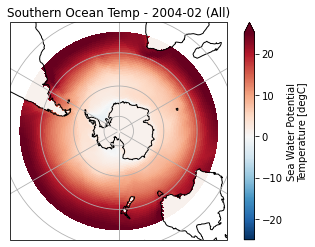

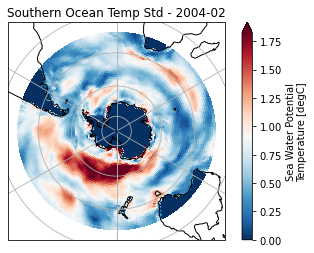

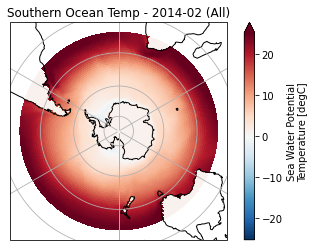

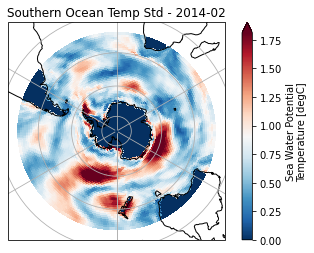

In [17]:
singleAllDateCalc('2004-02', True, 1)
singleAllDateCalc('2014-02', True, 3)

<br>
Average (across all data sets) change in temperature between Febuary 2004 and 2014.

Average Ocean temperature for plot 1 (2014-02 vs 2004-02)(Set All): 0.093 Celsius
Average Ocean temperature standard deviation for plot 2 (2014-02 vs 2004-02): 0.799 Celsius


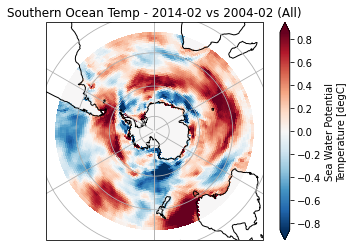

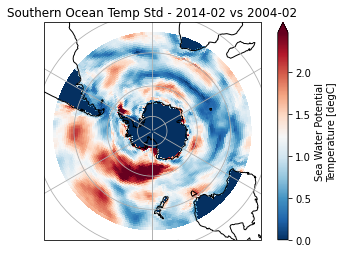

In [18]:
rangeAllCompareCalc('2004-02', '2014-02', True, 1)

<br>
Individual plots of change in temperature between Febuary 2004 and 2014 for each data set.

Average Ocean temperature for plot 0 (2014-02 vs 2004-02)(Set 0): 0.302 Celsius
Average Ocean temperature for plot 1 (2014-02 vs 2004-02)(Set 1): 0.069 Celsius
Average Ocean temperature for plot 2 (2014-02 vs 2004-02)(Set 2): -0.113 Celsius
Average Ocean temperature for plot 3 (2014-02 vs 2004-02)(Set 3): -0.033 Celsius
Average Ocean temperature for plot 4 (2014-02 vs 2004-02)(Set 4): 0.239 Celsius


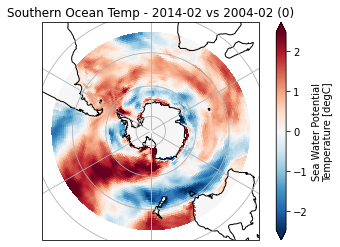

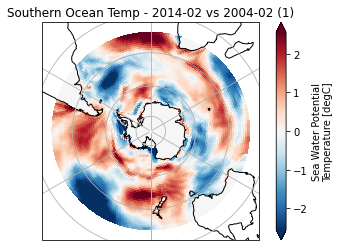

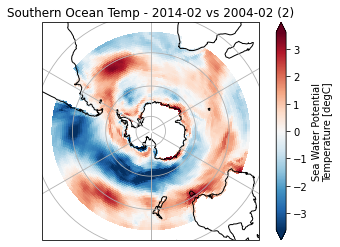

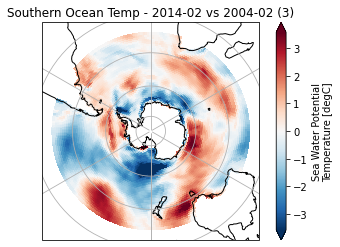

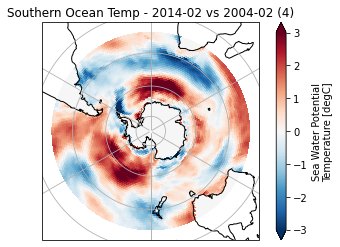

In [19]:
for i in range(fileCount):
    rangeSoloCompareCalc('2004-02', '2014-02', i, i)

<br>
<b>Comparison of Southern Ocean Temperature September 2004 - 2014</b><br>
Temperature and standard deviation plots across all data sets for start and end time.

Average Ocean temperature for plot 1 (2004-09)(Set All): 6.86 Celsius
Average Ocean temperature standard deviation for plot 2 (2004-09): 0.204 Celsius
Average Ocean temperature for plot 3 (2014-09)(Set All): 6.983 Celsius
Average Ocean temperature standard deviation for plot 4 (2014-09): 0.209 Celsius


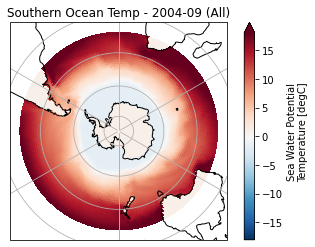

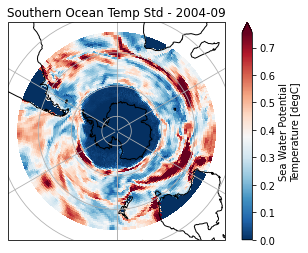

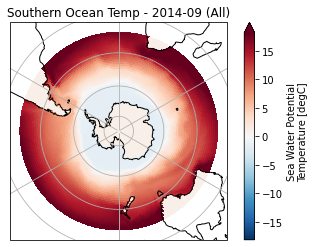

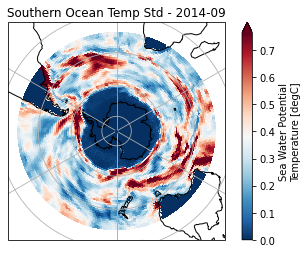

In [20]:
singleAllDateCalc('2004-09', True, 1)
singleAllDateCalc('2014-09', True, 3)

<br>
Average (across all data sets) change in temperature between September 2004 and 2014.

Average Ocean temperature for plot 1 (2014-09 vs 2004-09)(Set All): 0.123 Celsius
Average Ocean temperature standard deviation for plot 2 (2014-09 vs 2004-09): 0.311 Celsius


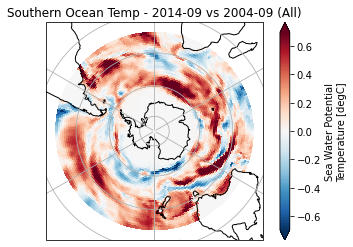

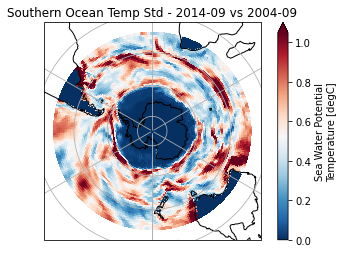

In [21]:
rangeAllCompareCalc('2004-09', '2014-09', True, 1)

<br>
Individual plots of change in temperature between September 2004 and 2014 for each data set.

Average Ocean temperature for plot 0 (2014-09 vs 2004-09)(Set 0): 0.234 Celsius
Average Ocean temperature for plot 1 (2014-09 vs 2004-09)(Set 1): 0.029 Celsius
Average Ocean temperature for plot 2 (2014-09 vs 2004-09)(Set 2): 0.074 Celsius
Average Ocean temperature for plot 3 (2014-09 vs 2004-09)(Set 3): 0.159 Celsius
Average Ocean temperature for plot 4 (2014-09 vs 2004-09)(Set 4): 0.118 Celsius


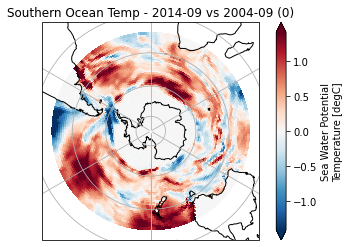

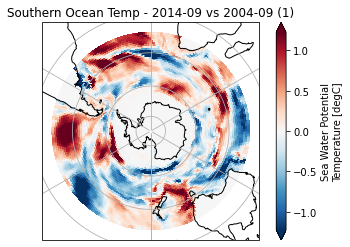

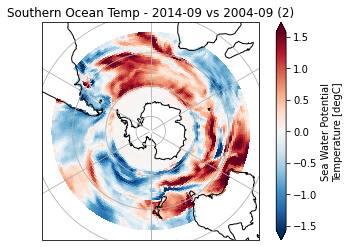

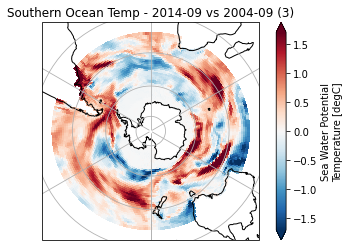

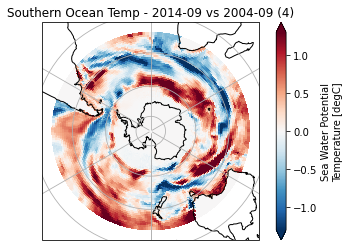

In [22]:
for i in range(fileCount):
    rangeSoloCompareCalc('2004-09', '2014-09', i, i)

Looking at both the Febuary and September profiles a small average increase in overall ocean temperature can be seen (0.093 and 0.123 degrees respectively), however both increases are noticably smaller than the respective data sets average standard deviation (0.799 and 0.311). From this uncertainty between models no confident comment can be made on the change in ocean temperature over the last 10 years.

With the potential size of temperature changes for this time period (in the region of 0.1) greater accuracy in measurement is needed, with reduced deviation between data sets to provide confidence in results.

<br>
<b>Comparison of Average Southern Ocean Temperature over the last 10 years</b><br>
Mean Southern Ocean temperature for January 2004 to December 2014 across area and datasets.

Mean Annual rolling Temp on 2004-12 (set All): 8.718 Celcius
Mean Annual rolling Temp on 2014-12 (set All): 8.839 Celcius
Mean Rolling Temp increase across time (set All): 0.1206 Celcius


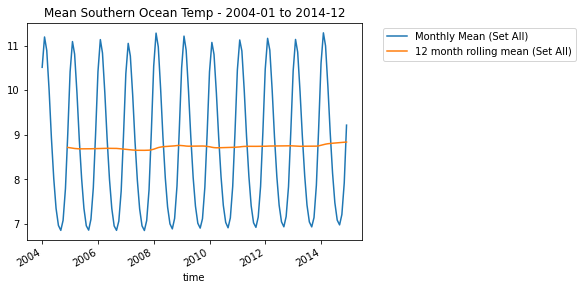

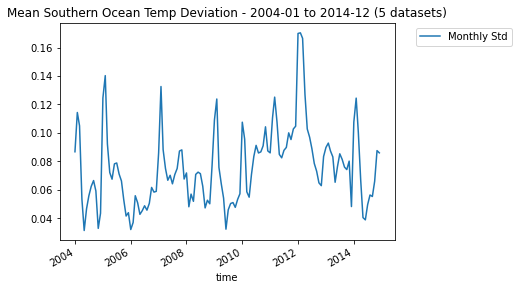

In [23]:
rangeAllDateCalc2('2004-01','2014-12', True, 1)

Mean Southern Ocean temperature for January 2004 to December 2014 across area.

Mean Annual rolling Temp on 2004-12 (set 0): 8.662 Celcius
Mean Annual rolling Temp on 2014-12 (set 0): 8.902 Celcius
Mean Rolling Temp increase across time (set 0): 0.2401 Celcius
Mean Annual rolling Temp on 2004-12 (set 1): 8.742 Celcius
Mean Annual rolling Temp on 2014-12 (set 1): 8.776 Celcius
Mean Rolling Temp increase across time (set 1): 0.0338 Celcius
Mean Annual rolling Temp on 2004-12 (set 2): 8.731 Celcius
Mean Annual rolling Temp on 2014-12 (set 2): 8.778 Celcius
Mean Rolling Temp increase across time (set 2): 0.0474 Celcius
Mean Annual rolling Temp on 2004-12 (set 3): 8.73 Celcius
Mean Annual rolling Temp on 2014-12 (set 3): 8.82 Celcius
Mean Rolling Temp increase across time (set 3): 0.0899 Celcius
Mean Annual rolling Temp on 2004-12 (set 4): 8.727 Celcius
Mean Annual rolling Temp on 2014-12 (set 4): 8.919 Celcius
Mean Rolling Temp increase across time (set 4): 0.1918 Celcius


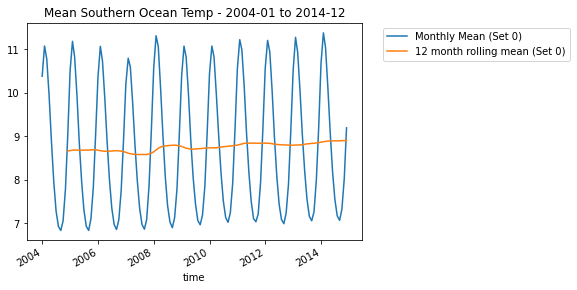

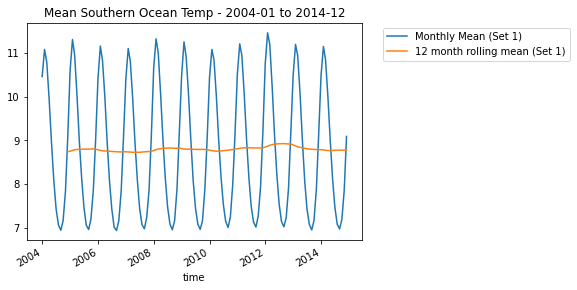

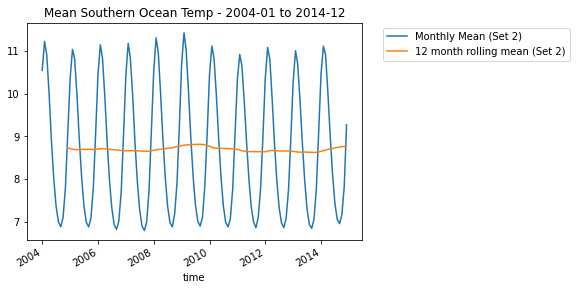

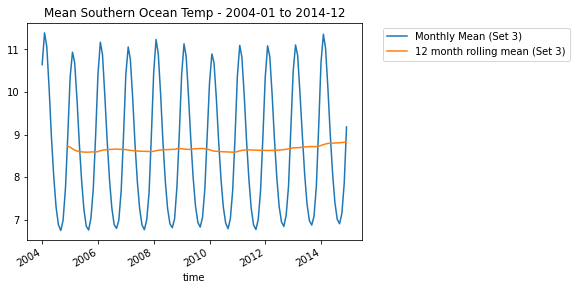

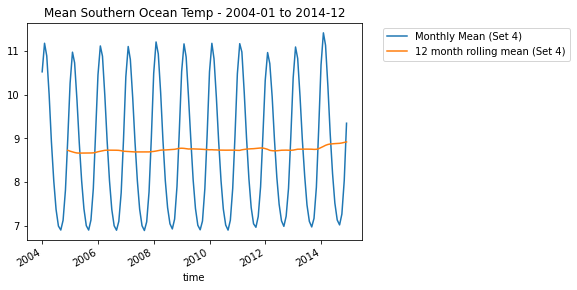

In [24]:
for i in range(fileCount):
    rangeSoloDateCalc('2004-01', '2014-12', i, i)

Placing the 5 above mean Southern Ocean temperature plots on the same graph yeilds the following plots, allowing for easy comparisons between data sets.

Mean Annual rolling Temp on 2004-12 (set 0): 8.662 Celcius
Mean Annual rolling Temp on 2014-12 (set 0): 8.902 Celcius
Mean Rolling Temp increase across time (set 0): 0.2401 Celcius
Mean Annual rolling Temp on 2004-12 (set 1): 8.742 Celcius
Mean Annual rolling Temp on 2014-12 (set 1): 8.776 Celcius
Mean Rolling Temp increase across time (set 1): 0.0338 Celcius
Mean Annual rolling Temp on 2004-12 (set 2): 8.731 Celcius
Mean Annual rolling Temp on 2014-12 (set 2): 8.778 Celcius
Mean Rolling Temp increase across time (set 2): 0.0474 Celcius
Mean Annual rolling Temp on 2004-12 (set 3): 8.73 Celcius
Mean Annual rolling Temp on 2014-12 (set 3): 8.82 Celcius
Mean Rolling Temp increase across time (set 3): 0.0899 Celcius
Mean Annual rolling Temp on 2004-12 (set 4): 8.727 Celcius
Mean Annual rolling Temp on 2014-12 (set 4): 8.919 Celcius
Mean Rolling Temp increase across time (set 4): 0.1918 Celcius


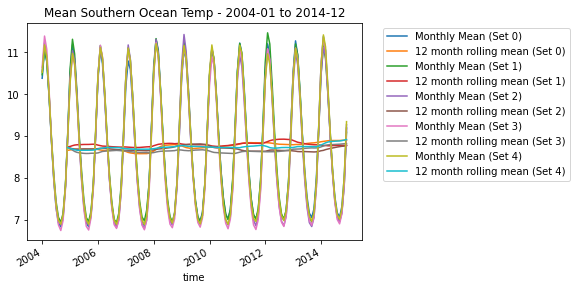

In [25]:
for i in range(fileCount):
    rangeSoloDateCalc('2004-01', '2014-12', i, 1)

<br>

#### Conclusion
Across the time period of January 2004 to December 2014 there was an indication of a small (0.12 Celcius) increase in average Ocean temperature across 5 data sets. This finding however has little confidence due to the variability between data sets for ocean temperatures changes, with different data sets identifying different temperature changes for the same location as shown in the Febuary and September analysis.